# Heat equation 1D with variable coefficient
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

$$
\partial_t u = \left(a(x)u_x\right)_x
$$

within $\Omega = [0,1]$ where $a(x)=1 + x^2$ and $u(0,x)= \sin(\pi x)$. We also assume zero Dirichlet boundary conditions.

Its analytical solution using separation of variables is given by



## Libraries

In [1]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [2]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [3]:
def Kphiphi_assembly(Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary
  
  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param)
  val2 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 0)
  val3 = K_ddot(kernel, Xomega, Xomega, k_param, 1, 1)
  #val3 = val2
  val4 = K_ddddot(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1)
  val = val1 - h*val2 - h*(val3 - h*val4)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val2 = K_ddot(kernel, Xomega, Xboundary, k_param, 0, 0)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [4]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = K_ddot(kernel, Xomega, Xtest, k_param, 0, 0)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [5]:
# X_full
Xfull = np.linspace(0,1,52)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = heat_u0(Xomega)
# Time step
h = 0.01

Build `Kphiphi`

In [6]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = 0.5)

Build `y_prev`

In [7]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [8]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-10*R,y_prev)

Get `K(Xtest,Xfull)`

In [9]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

In [10]:
u_next = np.dot(Kphi.T,sol)

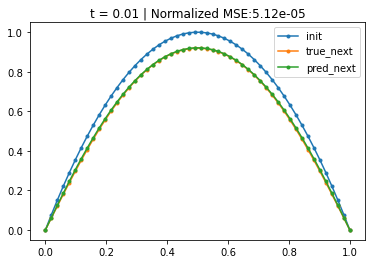

In [11]:
# Initial condition with Numerical vs. Analytical
plt.plot(Xfull,heat_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,heat_sol(Xfull,h,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,heat_sol(Xfull,h,5))/mean_squared_error(0*heat_sol(Xfull,h,5),heat_sol(Xfull,h,5))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [12]:
t = 0.2
steps = int(t//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

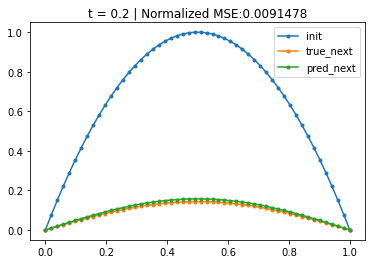

In [13]:
# Initial condition
plt.plot(Xfull,heat_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,heat_sol(Xfull,t,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,heat_sol(Xfull,t,5))/mean_squared_error(0*heat_sol(Xfull,t,5),heat_sol(Xfull,t,5))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

### Experiment 1

- $h = $ `1e-1`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [14]:
# Experiment 1.1 - L2-norms
L2_norms_1 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-1
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.08336324370734498
0.0835159036676017
0.08347473927557378
0.08347153672228681
0.08347080418073623
0.08347019854310574
0.08346942568300524
0.08346852647769583


- $h = $ `1e-2`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [15]:
# Experiment 1.2 - L2-norms
L2_norms_2 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-2
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009449766667162457
0.009742184968627093
0.009712161443109624
0.009700725402854028
0.009693354999896733
0.009687931420231912
0.009683628479598107
0.009679189108832238


- $h = $ `1e-3`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [16]:
# Experiment 1.3 - L2-norms
L2_norms_3 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-3
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.0006888882799566955
0.0009683564903181428
0.0009861331284662376
0.0009860921652705172
0.0009791066304712414
0.0009619554851421499
0.0009293284093222618
0.0008759220065231782


- $h = $ `1e-4`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [17]:
# Experiment 1.4 - L2-norms
L2_norms_4 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-4
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.0007213803946924724
0.0001758081394006785
5.216639204821972e-05
6.363703211061588e-05
8.413463404259338e-05
9.426721908288604e-05
9.570498626042437e-05
8.780349183970956e-05


- $h = $ `1e-5`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [18]:
# Experiment 1.5 - L2-norms
L2_norms_5 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-5
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.004393942970957471
0.0019991031679421636
0.000994567526661165
0.0004980586522265487
0.00024260755138694223
0.0001127632877350089
4.963344986462609e-05
2.3822254359410697e-05


Text(0.5, 1.0, '$h = 1e-5$')

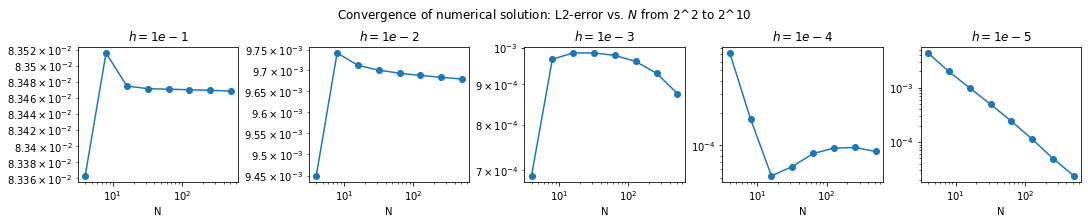

In [19]:
# Different plots
fig, axs = plt.subplots(nrows = 1, ncols=5 , figsize = (15,3),constrained_layout=True)
fig.suptitle('Convergence of numerical solution: L2-error vs. $N$ from 2^2 to 2^10')
axs[0].loglog(xrange, L2_norms_1, marker = 'o')
axs[0].set_xlabel('N')
axs[0].set_title('$h = 1e-1$')
axs[1].loglog(xrange, L2_norms_2, marker = 'o')
axs[1].set_xlabel('N')
axs[1].set_title('$h = 1e-2$')
axs[2].loglog(xrange, L2_norms_3, marker = 'o')
axs[2].set_xlabel('N')
axs[2].set_title('$h = 1e-3$')
axs[3].loglog(xrange, L2_norms_4, marker = 'o')
axs[3].set_xlabel('N')
axs[3].set_title('$h = 1e-4$')
axs[4].loglog(xrange, L2_norms_5, marker = 'o')
axs[4].set_xlabel('N')
axs[4].set_title('$h = 1e-5$')

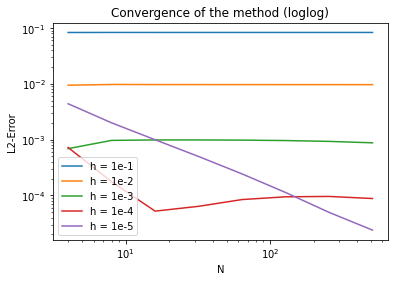

In [20]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'h = 1e-1')
plt.loglog(xrange,L2_norms_2,label = 'h = 1e-2')
plt.loglog(xrange,L2_norms_3,label = 'h = 1e-3')
plt.loglog(xrange,L2_norms_4,label = 'h = 1e-4')
plt.loglog(xrange,L2_norms_5,label = 'h = 1e-5')
plt.xlabel('N')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

### Experiment 2

- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^5$

In [21]:
# Experiment 2.1 - L2-norms
L2_norms_1 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**5+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009700725402854028
0.0009860921652705172
6.363703211061588e-05
0.0004980586522265487


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{6}$

In [24]:
# Experiment 2.2 - L2-norms
L2_norms_2 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**6+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009693354999896733
0.0009791066304712414
8.413463404259338e-05
0.00024260755138694223


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{7}$

In [26]:
# Experiment 2.3 - L2-norms
L2_norms_3 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**7+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009687931420231912
0.0009619554851421499
9.426721908288604e-05
0.0001127632877350089


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{8}$

In [27]:
# Experiment 2.4 - L2-norms
L2_norms_4 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**8+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009683628479598107
0.0009293284093222618
9.570498626042437e-05
4.963344986462609e-05


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{9}$

In [28]:
# Experiment 2.5 - L2-norms
L2_norms_5 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**9+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009679189108832238
0.0008759220065231782
8.780349183970956e-05
2.3822254359410697e-05


Text(0.5, 1.0, '$N = 2^9$')

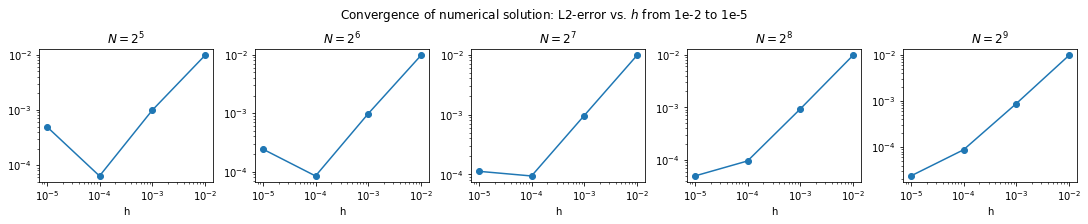

In [29]:
# Different plots
fig, axs = plt.subplots(nrows = 1, ncols=5 , figsize = (15,3),constrained_layout=True)
fig.suptitle('Convergence of numerical solution: L2-error vs. $h$ from 1e-2 to 1e-5')
axs[0].loglog(xrange, L2_norms_1, marker = 'o')
axs[0].set_xlabel('h')
axs[0].set_title('$N = 2^5$')
axs[1].loglog(xrange, L2_norms_2, marker = 'o')
axs[1].set_xlabel('h')
axs[1].set_title('$N = 2^6$')
axs[2].loglog(xrange, L2_norms_3, marker = 'o')
axs[2].set_xlabel('h')
axs[2].set_title('$N = 2^7$')
axs[3].loglog(xrange, L2_norms_4, marker = 'o')
axs[3].set_xlabel('h')
axs[3].set_title('$N = 2^8$')
axs[4].loglog(xrange, L2_norms_5, marker = 'o')
axs[4].set_xlabel('h')
axs[4].set_title('$N = 2^9$')

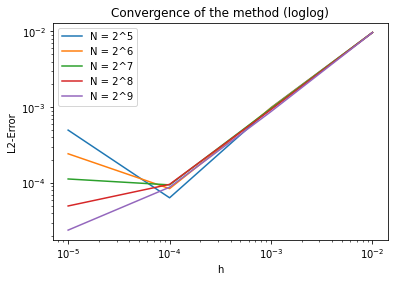

In [30]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'N = 2^5')
plt.loglog(xrange,L2_norms_2,label = 'N = 2^6')
plt.loglog(xrange,L2_norms_3,label = 'N = 2^7')
plt.loglog(xrange,L2_norms_4,label = 'N = 2^8')
plt.loglog(xrange,L2_norms_5,label = 'N = 2^9')
plt.xlabel('h')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()